# PSD analysis if spike data
This is based on `psd_analysis.ipynb` in this same directory. 

* 2/10/2024 setup
* 10/30/2024 update using dual plane imaging data. this is also an analysis for an R01 with YP due 11/2024.
  * Refactorings
* Works as of 10/31/2024

In [1]:
import sys
import json
import matplotlib.pyplot as plt
from os.path import join, dirname
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.fftpack import fft
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.stats import t

sys.path.append("/home/gergely/code/sleep/")

from src.classes.imaging_data_class import ImagingData
from src.classes.suite2p_class import Suite2p as s2p
import src.classes.behavior_class as bc
from src import frequency_psd as fp

Mice: 
"140502_5", "140502_3", "5HT2afl05b_1", "5HT2afl05b_2", "sert52b_1", "sert52b_5", "sert54a_5"

In [2]:
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/dock11c5/8_2/TSeries-08022024-1036-001/TSeries-08022024-1036-001.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11c5/8_2/TSeries-08022024-1036-002/TSeries-08022024-1036-002.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b2/6_17/TSeries-06172024-0946-001/TSeries-06172024-0946-001.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b2/6_17/TSeries-06172024-0946-003/TSeries-06172024-0946-003.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b1/6_17/TSeries-06172024-0946-001/TSeries-06172024-0946-001.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b1/7_31/TSeries-07312024-1030-002/TSeries-07312024-1030-002.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b1/8_3/TSeries-08022024-1036-001/TSeries-08022024-1036-001.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b1/8_3/TSeries-08022024-1036-002/TSeries-08022024-1036-002.sima/",
]

In [3]:
spks = {}
planes = {0: "dendrites", 1: "soma"}
for folder in sima_folders:
    for plane, plane_name in planes.items():
        s2p_data = s2p(join(folder, "suite2p"))
        spikes = s2p_data.get_spikes(plane=plane)
        # z scoring
        zscored_spikes = zscore(spikes, axis=1)

        # Add the z-scored data to the dictionary
        if plane_name not in spks:
            spks[plane_name] = []  # Initialize a list for each plane
        spks[plane_name].append(zscored_spikes)

mob_immobs = []
for folder in sima_folders:
    data = join(folder, "behavior", "mobility_immobility.json")
    with open(data, "r") as f:
        mob_immobs.append(np.array(json.load(f)))

In [4]:
moving_immobile_spikes = {}

# Assuming `spks` is a dictionary with keys ('dendrites', 'soma') and values being lists of arrays
# Assuming `mob_immobs` is a list of mobility data arrays, one for each spike array in `spks`
for key, spk_list in spks.items():
    moving_spikes_list = []
    immobile_spikes_list = []

    for spk, mob_immob in zip(spk_list, mob_immobs):
        try:
            # Convert spk and mob_immob to numpy arrays if they are lists
            spk = np.array(spk) if isinstance(spk, list) else spk
            mob_immob = (
                np.array(mob_immob) if isinstance(mob_immob, list) else mob_immob
            )

            print(spk.shape, mob_immob.shape)

            # Check if shapes are mismatched
            if spk.shape[1] != mob_immob.shape[0]:
                print("shapes mismatched")

                # Create an interpolation function for mob_immob
                x = np.linspace(0, 1, mob_immob.shape[0])
                f = interp1d(x, mob_immob, kind="linear")

                # Create a new x array matching the spk shape and interpolate
                new_x = np.linspace(0, 1, spk.shape[1])
                mob_immob_interpolated = f(new_x)

                # Convert interpolated values to boolean if necessary
                mob_immob_interpolated = (
                    mob_immob_interpolated >= 0.5
                )  # Adjust this threshold as needed
            else:
                mob_immob_interpolated = mob_immob

            # Split spikes into moving and immobile based on mobility data
            moving_spikes = spk[:, mob_immob_interpolated == 1]
            immobile_spikes = spk[:, mob_immob_interpolated != 1]

            # Append the results to the respective lists
            moving_spikes_list.append(moving_spikes)
            immobile_spikes_list.append(immobile_spikes)

        except ValueError as e:  # Adjust exception type if needed
            print(f"Error processing spike and mobility data for key '{key}': {e}")
            # Handle or log the error appropriately

    # Store the results in the `moving_immobile_spikes` dictionary
    moving_immobile_spikes[key] = {
        "moving_spikes": moving_spikes_list,
        "immobile_spikes": immobile_spikes_list,
    }

# Now `moving_immobile_spikes` contains the keys from the input dictionary `spks`,
# with each key having a dictionary of both "moving_spikes" and "immobile_spikes" lists.


(308, 20375) (20374,)
shapes mismatched
(304, 20375) (20374,)
shapes mismatched
(144, 24585) (24584,)
shapes mismatched
(72, 24585) (24584,)
shapes mismatched
(162, 24585) (24541,)
shapes mismatched
(112, 19284) (19283,)
shapes mismatched
(179, 20375) (20374,)
shapes mismatched
(295, 20375) (20374,)
shapes mismatched
(265, 20375) (20374,)
shapes mismatched
(240, 20375) (20374,)
shapes mismatched
(138, 24585) (24584,)
shapes mismatched
(122, 24585) (24584,)
shapes mismatched
(285, 24585) (24541,)
shapes mismatched
(380, 19284) (19283,)
shapes mismatched
(349, 20375) (20374,)
shapes mismatched
(344, 20375) (20374,)
shapes mismatched


In [5]:
# Initialize the dictionaries with lists to store multiple arrays for PSD calculations
psd_data = {
    key: {"moving": {"freq": [], "psd": []}, "immobile": {"freq": [], "psd": []}}
    for key in moving_immobile_spikes.keys()
}


# Assuming `fp.calculate_psd` is your function to calculate PSD
for key, data in moving_immobile_spikes.items():
    # Calculate PSD for moving spikes
    for mov_data in data["moving_spikes"]:
        freq, psd = fp.calculate_psd(mov_data, 30)  # Adjust parameters as needed
        psd_data[key]["moving"]["freq"].append(freq)
        psd_data[key]["moving"]["psd"].append(np.mean(psd, axis=0))

    # Calculate PSD for immobile spikes
    for imm_data in data["immobile_spikes"]:
        freq, psd = fp.calculate_psd(imm_data, 30)  # Adjust parameters as needed
        psd_data[key]["immobile"]["freq"].append(freq)
        psd_data[key]["immobile"]["psd"].append(np.mean(psd, axis=0))

# Now `psd_data` contains the PSD information for "dendrites" and "soma",
# separated into "moving" and "immobile" categories, which can be easily used for plotting.


In [6]:
def resample_psd_to_common_freq(psd_dict, target_freqs):
    """
    Resample PSD values in a dictionary to align with a common set of frequency points.

    Parameters:
    - psd_dict: Dictionary containing "freq" and "psd" keys.
    - target_freqs: 1D numpy array of target frequency points for the resampling.

    Returns:
    - Resampled PSD values aligned with target_freqs.
    """
    resampled_psds = []

    for freq, psd in zip(psd_dict["freq"], psd_dict["psd"]):
        # Create an interpolation function based on the original freq and psd
        interp_func = interp1d(
            freq, psd, kind="linear", bounds_error=False, fill_value=0
        )
        # Use this function to calculate the PSD values at the target frequencies
        resampled_psd = interp_func(target_freqs)
        resampled_psds.append(resampled_psd)

    return np.array(resampled_psds)

In [7]:
def calculate_mean_sem(data):
    """Calculate the mean and standard error of the mean (SEM) of the data."""
    mean = np.mean(data, axis=0)
    sem = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
    return mean, sem


def confidence_interval(data, confidence=0.95):
    """Calculate the t-distribution based confidence interval for the given data."""
    sem = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
    df = data.shape[0] - 1  # Degrees of freedom
    multiplier = t.ppf((1 + confidence) / 2.0, df)
    return sem * multiplier

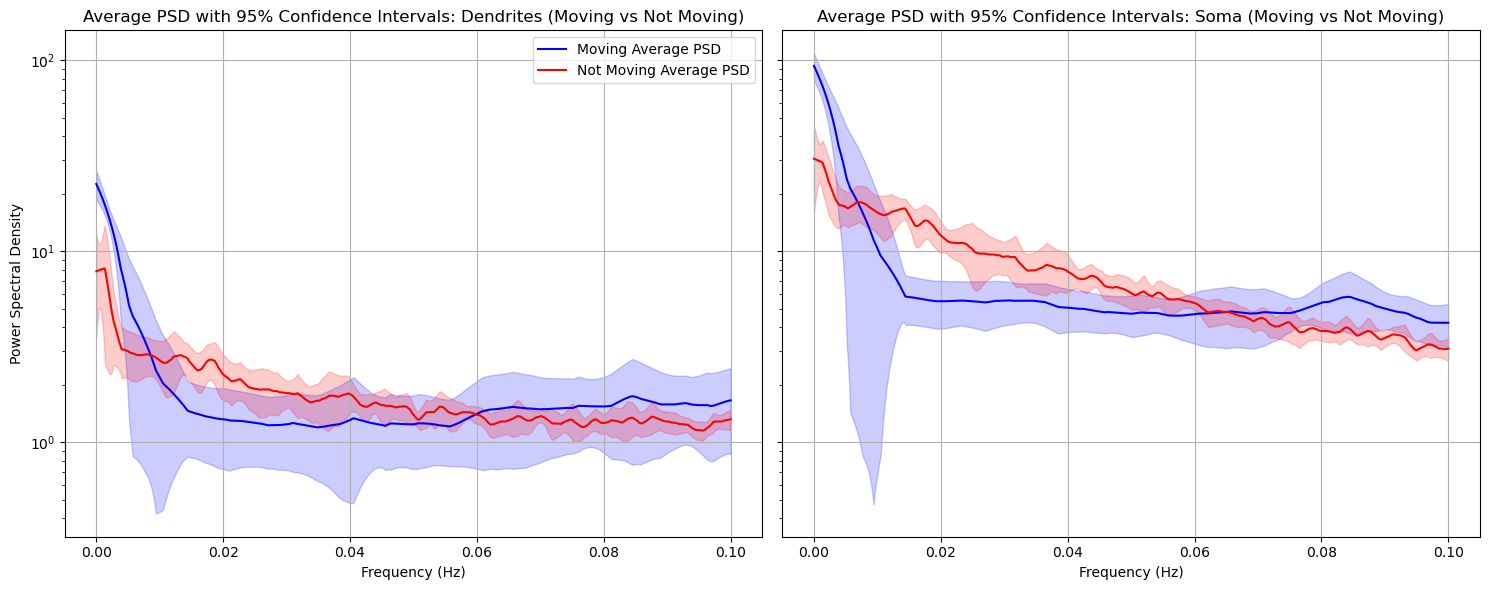

In [8]:
# Plotting the PSD data
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Define target frequencies for resampling
target_freqs = np.linspace(0, 0.1, num=1000)

for i, key in enumerate(psd_data.keys()):
    # Resample and calculate mean and confidence interval for moving and immobile data
    moving_resampled_psds = resample_psd_to_common_freq(
        {
            "freq": psd_data[key]["moving"]["freq"],
            "psd": psd_data[key]["moving"]["psd"],
        },
        target_freqs,
    )
    notmoving_resampled_psds = resample_psd_to_common_freq(
        {
            "freq": psd_data[key]["immobile"]["freq"],
            "psd": psd_data[key]["immobile"]["psd"],
        },
        target_freqs,
    )

    mean_moving_resampled_psd, sem_moving_resampled_psd = calculate_mean_sem(
        moving_resampled_psds
    )
    mean_notmoving_resampled_psd, sem_notmoving_resampled_psd = calculate_mean_sem(
        notmoving_resampled_psds
    )

    # Calculate the confidence interval for the mean PSD values
    ci_moving_resampled_psd = confidence_interval(moving_resampled_psds)
    ci_notmoving_resampled_psd = confidence_interval(notmoving_resampled_psds)

    # Plot mean PSD for moving and not moving
    axes[i].plot(
        target_freqs,
        mean_moving_resampled_psd,
        label="Moving Average PSD",
        color="blue",
    )
    axes[i].plot(
        target_freqs,
        mean_notmoving_resampled_psd,
        label="Not Moving Average PSD",
        color="red",
    )

    # Add shaded confidence interval around the mean PSD
    axes[i].fill_between(
        target_freqs,
        mean_moving_resampled_psd - ci_moving_resampled_psd,
        mean_moving_resampled_psd + ci_moving_resampled_psd,
        color="blue",
        alpha=0.2,
    )
    axes[i].fill_between(
        target_freqs,
        mean_notmoving_resampled_psd - ci_notmoving_resampled_psd,
        mean_notmoving_resampled_psd + ci_notmoving_resampled_psd,
        color="red",
        alpha=0.2,
    )

    axes[i].set_title(
        f"Average PSD with 95% Confidence Intervals: {key.capitalize()} (Moving vs Not Moving)"
    )
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].grid(True)
    axes[i].set_yscale("log")

axes[0].set_ylabel("Power Spectral Density")
axes[0].legend()
plt.tight_layout()
plt.show()
